In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import warnings
warnings.filterwarnings("ignore")

In [2]:
url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
data=pd.read_csv(url, dtype={'fips':str})
data['location']=data.county+','+data.state
data['date'] = pd.to_datetime(data['date']) 
print('Last timestamp obtained:', data['date'].unique()[-1])

Last timestamp obtained: 2020-09-08T00:00:00.000000000


In [3]:
state_codes=pd.read_csv('abbr-name.csv', header=None)
state_codes.columns=['abbr', 'state']

In [4]:
def organize_data(df):
    df=df.sort_values(['state', 'county','date'], ascending=[1,1,1])
    return df

def get_state(df,state_name='Maryland'):
    state_df=df[df.state==state_name].reset_index().drop(columns=['index'], axis=0)
    return state_df


def get_state_agg(df,state_name):
    agg_df=get_state(df, state_name).groupby(['date']).sum()
    agg_df['state']=state_name
    return agg_df

def get_county(df,county_name='Baltimore city'):
    county_df=df[df.county==county_name].reset_index().drop(columns=['index'], axis=0)
    return county_df

def get_this(df,state_name='Maryland', county=False, county_name='Baltimore city'):
    if county==False:
        df_out=get_state_agg(get_state(df,state_name), state_name).reset_index()
    if county==True:
        df_out=get_county(get_state(df,state_name), county_name)
    return df_out

def get_date(df,start='2020-05-30', end='2020-05-30'):
    mask = (df['date'] >= start) & (df['date'] <= end)
    date_df=df[mask]
    return date_df

def plot_daily(df, county=True):
    #Given a dataframe, plot the daily increase.
    df['SM7']=df.daily.rolling(window=7).mean()
    df['SM14']=df.daily.rolling(window=14).mean()
    a,b=np.polyfit(df.index,df.daily,deg=1)
    plt.figure(figsize=(8,6))
    plt.plot(df.date, df.daily, marker='.', label='daily')
    plt.plot(df.date, np.ones(len(df))*df.daily.mean(), label='total avg')
    plt.plot(df.date, df.index*a+b, label='trend')
    plt.plot(df.date, df.SM14, label='SM14')
    plt.plot(df.date, df.SM7, label='SM7')
    plt.legend(loc='best')
    plt.xticks(rotation=45, fontsize=12)
    plt.ylim([0,max(df.daily)*1.05])
    if county==True:
        plt.title(str(df.county.unique())+', '+str(df.state.unique()))
    else:
        plt.title(str(df.state.unique()))
    plt.show()

def local_cases(data, ff_dct):
    for i in list(ff_dct.keys()):
        plot_daily(get_this(data,state_name=ff_dct[i], 
                            county=True, county_name=i))
        plt.show()
        
def state_cases(data, state_dct):
    for i in range(len(state_dct)):
        plot_daily(get_this(data,state_name=state_dct[i], 
                            county=False), county=False)
        plt.show()
def US_cases(data):
    data['US']=data.sum(axis=1)
    return data

def get_US(df):
    US_df=pd.DataFrame()
    US_df["Washington"]=get_state_agg(df, state_name="Washington").daily
    for i in (df.state.unique()):
        state_i=get_state_agg(df, state_name=i)
        US_df[i]=state_i.daily
    US_df=US_df.fillna(value=0)
    US_df.reindex(sorted(US_df.columns), axis=1)
    return US_df

def stack100(data, list_vals):
    #Convert data to a stacked version, up to 100% for a given day
    data[list_vals]=data[list_vals].divide(data[list_vals].sum(axis=1), axis=0)*100
    return data


In [5]:
states_list=list(state_codes.abbr.unique())
data['abbr']=data['state']
for i in range(len(states_list)):
    data['abbr'].replace(state_codes.loc[i]['state'], 
                         state_codes.loc[i]['abbr'], inplace=True)
data['daily']=data['cases']
data=organize_data(data)


for i in range(len(data)-1):
    if i==0: 
        data.daily.iloc[i]=data.cases.iloc[i]
    else:
        if data.county.iloc[i]!= data.county.iloc[i-1]:
            data.daily.iloc[i]=data.cases.iloc[i]
        else:
            data.daily.iloc[i] =data.cases.iloc[i]-data.cases.iloc[i-1]
    if  data.daily.iloc[i]<0:
        data.daily.iloc[i]=0

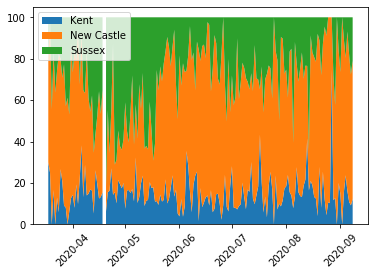

In [6]:
Del_data=get_state(data, 'Delaware')
Del_dct={}
for i in Del_data.county.unique():
    Del_dct[i]=get_this(data,state_name='Delaware', county=True, county_name=i)[['date','daily']]
Del_data_tot=Del_dct['Kent'].merge(right=Del_dct['New Castle'],
                         left_on='date', right_on='date', suffixes=['_Kent','_New_Castle'])
Del_data_tot=Del_data_tot.merge(right=Del_dct['Sussex'],
                         left_on='date', right_on='date')
Del_data_tot.columns=['date', 'daily_Kent','daily_New_Castle', 'daily_Sussex']
county_list=['daily_Kent','daily_New_Castle', 'daily_Sussex']

Del_data_100=stack100(Del_data_tot,county_list)
plt.stackplot(Del_data_tot.date, np.transpose(Del_data_100[county_list].to_numpy()), 
              labels=['Kent', 'New Castle', 'Sussex'])
plt.legend(['Kent', 'New Castle', 'Sussex'], loc='upper left')
plt.xticks(rotation='45')
plt.show()

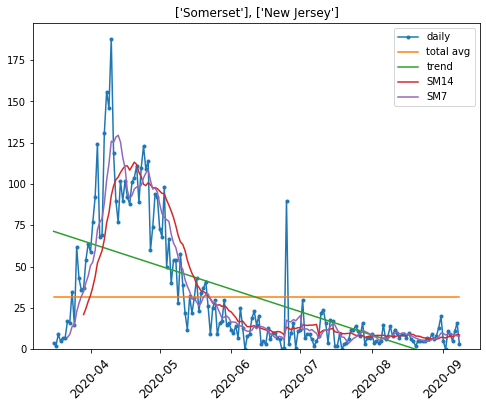

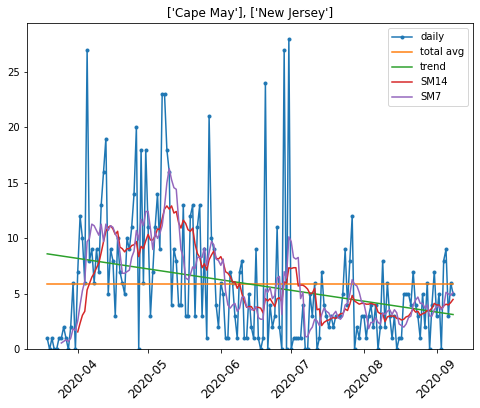

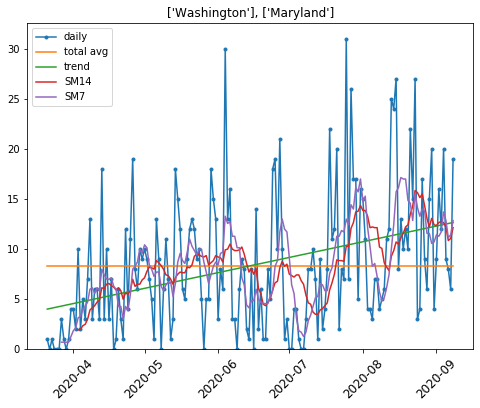

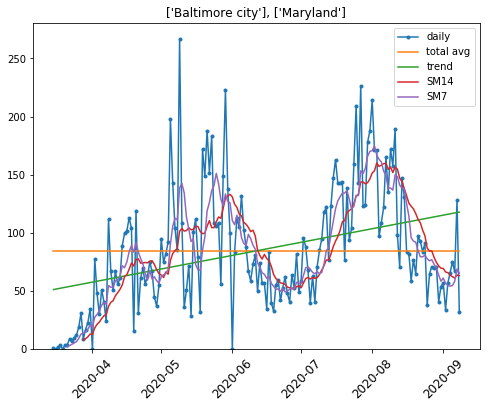

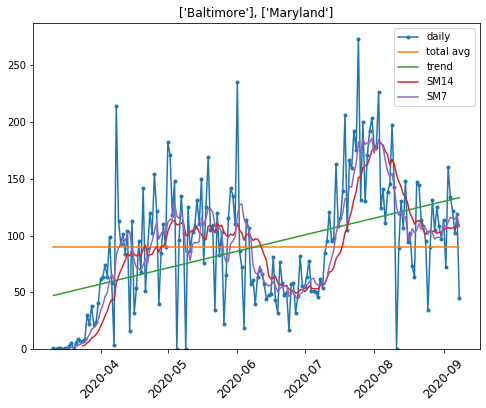

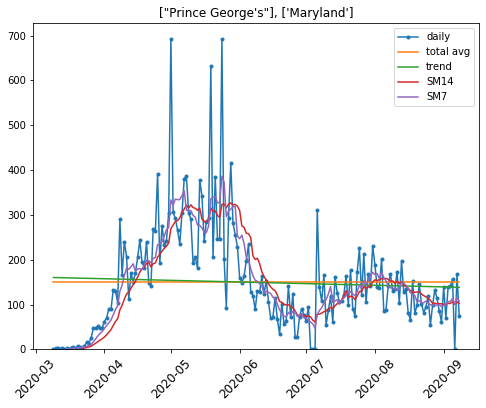

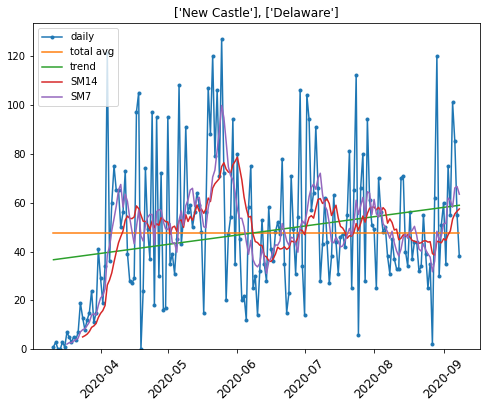

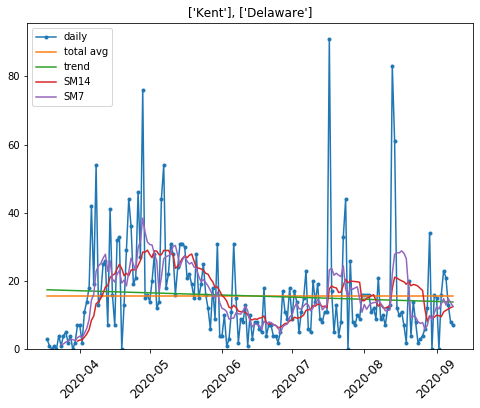

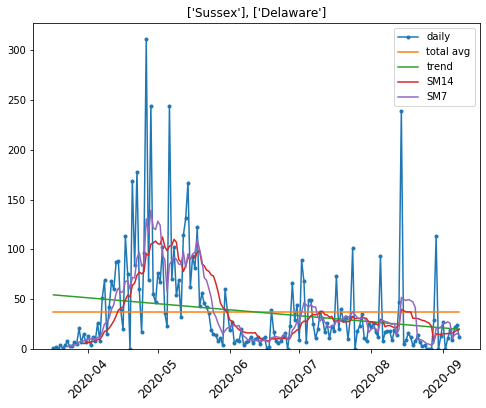

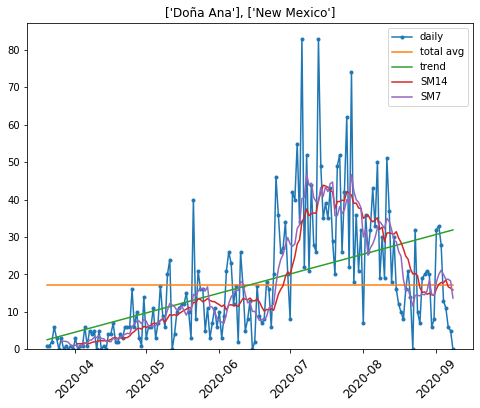

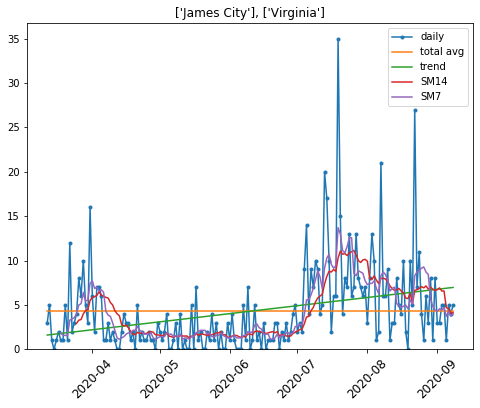

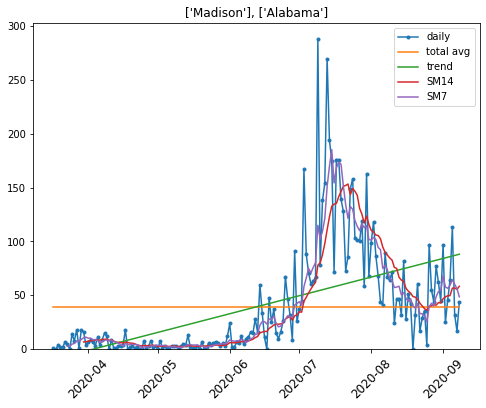

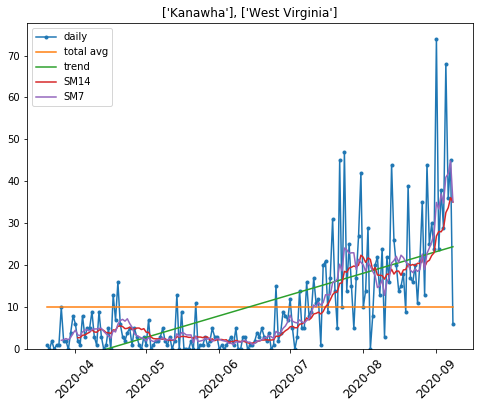

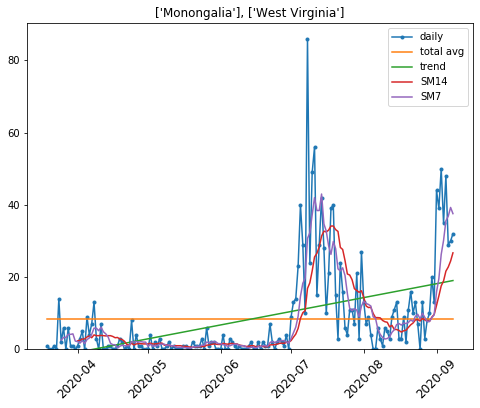

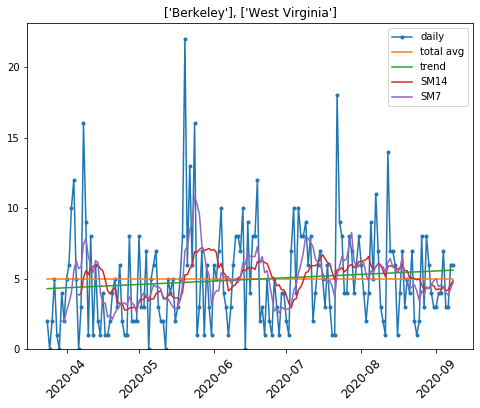

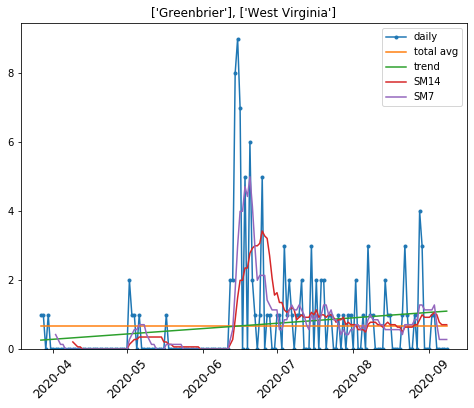

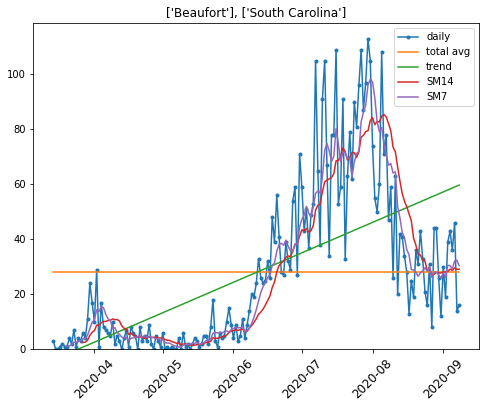

In [7]:
ff_dct={'Somerset':'New Jersey', 
        'Cape May':'New Jersey',
        'Washington':'Maryland', 
        'Baltimore city':'Maryland', 
        'Baltimore':'Maryland',
        'Prince George\'s':'Maryland',
        'New Castle':'Delaware',
        'Kent':'Delaware',
        'Sussex':'Delaware',
        'Doña Ana':'New Mexico', 
        'James City':'Virginia',
        'Madison':'Alabama',
        'Kanawha': 'West Virginia',
        'Monongalia':'West Virginia', 
        'Berkeley':'West Virginia',
       'Greenbrier':'West Virginia',
       'Beaufort':'South Carolina'}
local_cases(data,ff_dct)

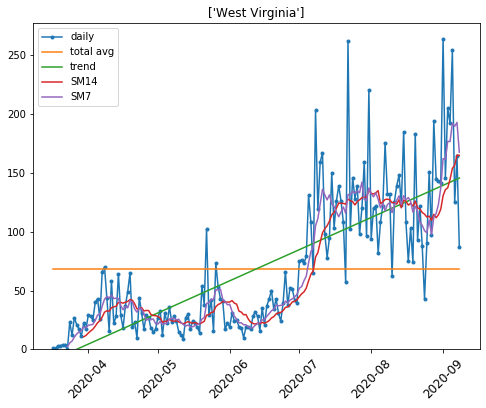

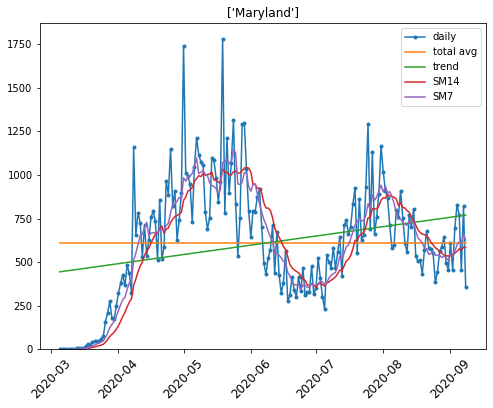

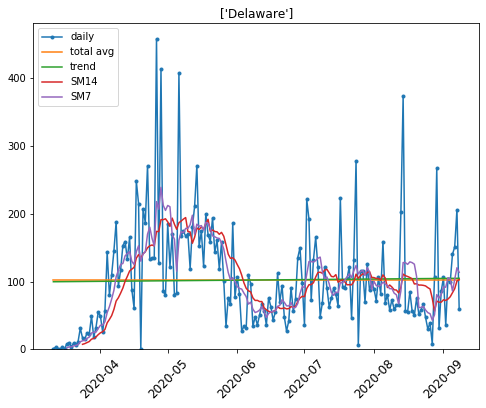

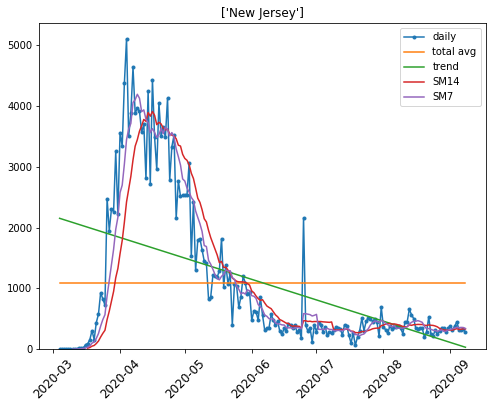

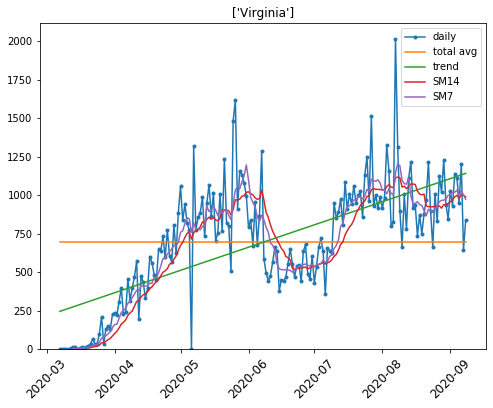

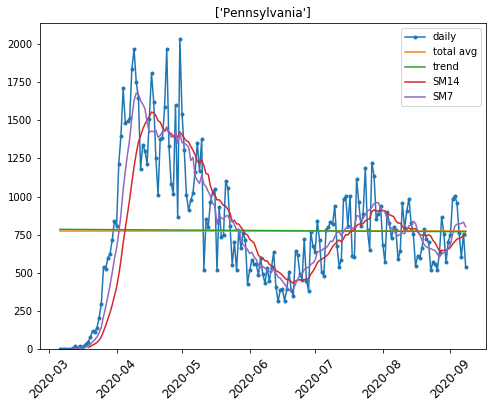

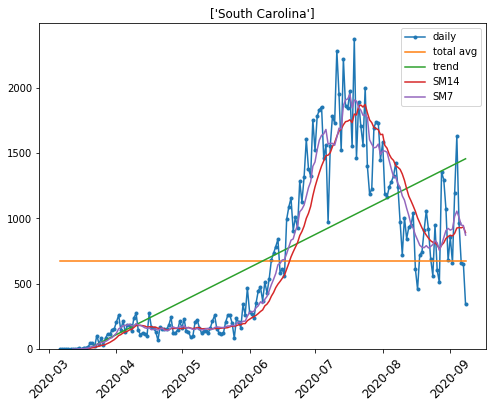

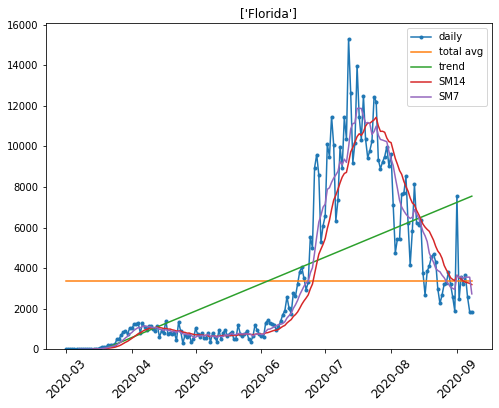

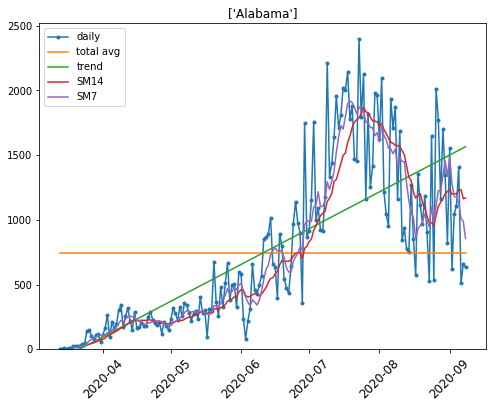

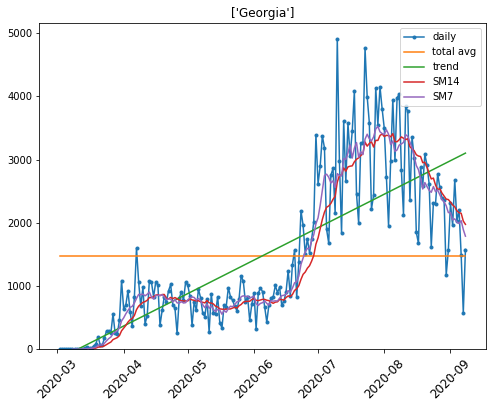

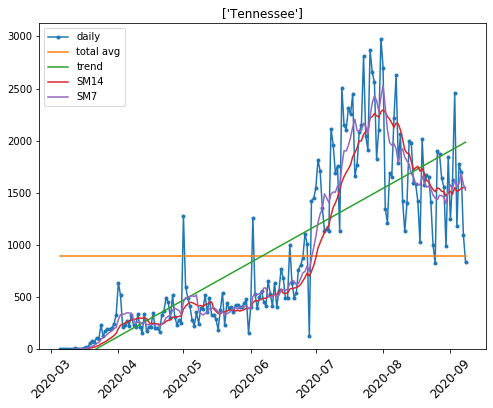

In [15]:
state=['West Virginia', 'Maryland', 'Delaware',  'New Jersey','Virginia', 'Pennsylvania','South Carolina', 'Florida',  'Alabama', 'Georgia', 'Tennessee']
state_cases(data,state)

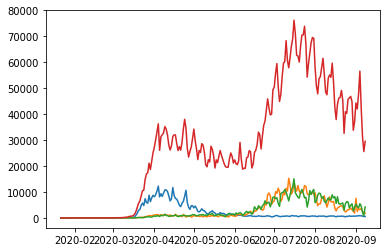

In [9]:
US_data=US_cases(get_US(data))
plt.plot(US_data["New York"])
plt.plot(US_data["Florida"])
plt.plot(US_data["Texas"])
plt.plot(US_data.US)
plt.show()


Why are we seeing such a drastic spike in cases? Breaking this down by state may help, though the plot will be messy.

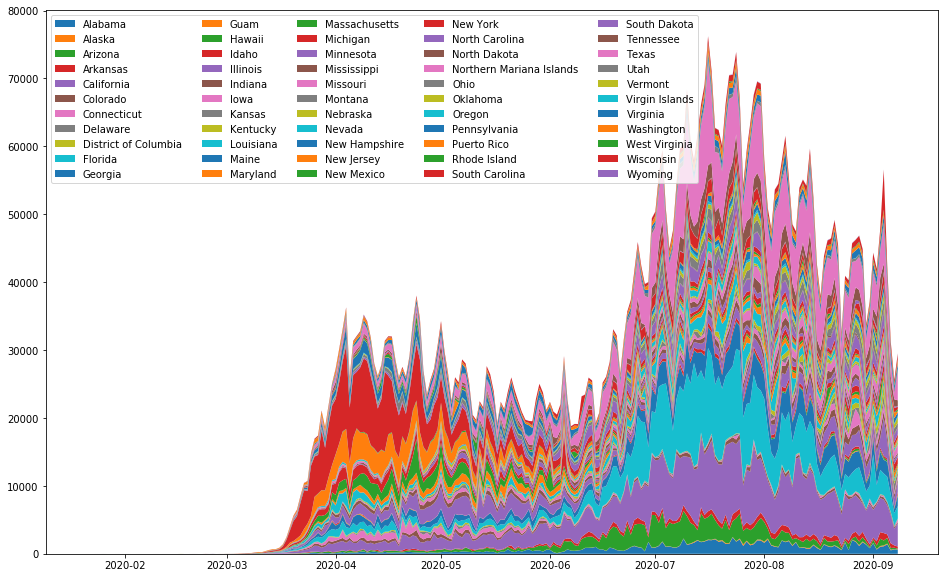

In [10]:
plt.figure(figsize=(16,10))
plt.stackplot(US_data.index, np.transpose(US_data[data.state.unique()].to_numpy()), 
              labels=data.state.unique())
plt.legend(loc='upper left', fontsize=10, ncol=5)
plt.show()


Let's check some of the states we've seen in the news throughout the pandemic. Most notably, NY, NJ, FL, Texas, etc.

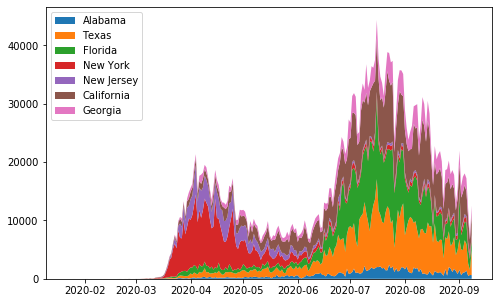

In [11]:
plt.figure(figsize=(8,5))
plt.stackplot(US_data.index, 
              np.transpose(US_data[['Alabama', 'Texas', 'Florida', 
                                    'New York', 'New Jersey', 'California', 'Georgia']].to_numpy()), 
              labels=['Alabama', 'Texas', 'Florida', 'New York', 'New Jersey', 'California', 'Georgia'])
plt.legend(loc='upper left', fontsize=10)
plt.show()

As we can see, it really comes down to where you are during this pandemic. New York has pretty much recovered, whereas Florida is exploding. Let's explore the U.S. Census Bureau designated regions.

In [12]:
#US Census Bureau designated regions

#South Atlantic
SA=['Delaware', 'Florida', 'Georgia', 'Maryland',
    'North Carolina', 'South Carolina', 'Virginia', 
    'District of Columbia', 'West Virginia']
#East North Central
ENC=['Illinois','Indiana', 'Michigan', 'Ohio', 'Wisconsin']
#West North Central
WNC=['Iowa', 'Kansas', 'Minnesota', 'Missouri', 
     'Nebraska', 'North Dakota', 'South Dakota']
#East South Central
ESC=['Alabama', 'Kentucky', 'Mississippi', 'Tennessee']
#West South Central
WSC=['Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
#New England
NE=['Connecticut', 'Maine', 'Massachusetts', 
    'New Hampshire', 'Rhode Island', 'Vermont']
#Mid-Atlantic
MA=['New Jersey', 'New York', 'Pennsylvania']
Mountain=['Arizona', 'Colorado', 'Idaho', 'Montana', 
          'Nevada', 'New Mexico', 'Utah', 'Wyoming']
Pacific=['Alaska', 'California', 'Hawaii', 
         'Oregon','Washington']
Region_list=[Pacific,WNC,NE,Mountain, ENC,MA,WSC,ESC,SA]

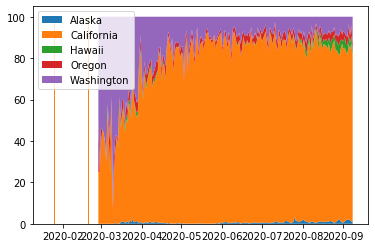

In [13]:
US_data=stack100(US_data,Pacific)
plt.stackplot(US_data.index, np.transpose(US_data[Pacific].to_numpy()), labels=Pacific)
plt.legend(Pacific, loc='upper left')
plt.show()

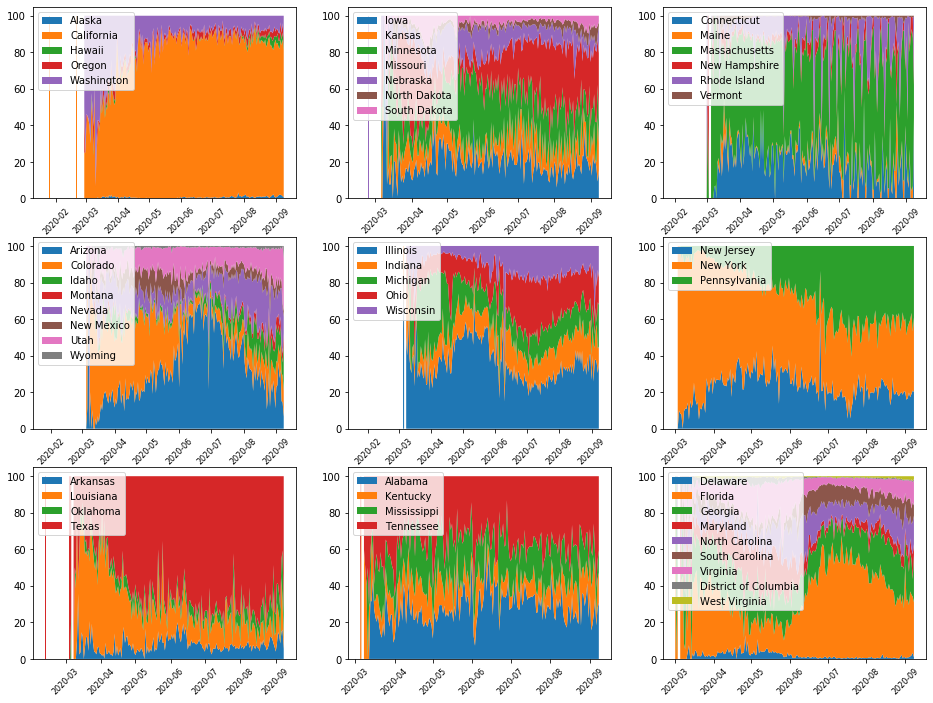

In [14]:
    
plt.figure(figsize=(16,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    US_data=stack100(US_data,Region_list[i])
    plt.stackplot(US_data.index, 
              np.transpose(US_data[Region_list[i]].to_numpy()), 
              labels=Region_list[i])
    plt.legend(loc='upper left', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)

plt.show()

We'll notice that there has been a shift in the majority of cases depending on the region. The Mid-West seems to grow relatively slowly due to the population sparsity. The Northeast had a tougher time back in March, but now the South and Pacific regions seem to be suffering in July. 